# Imports

In [2]:
!pip install braindecode==0.7
!pip install moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 6.7 MB/s eta 0:00:00
  Obtaining dependency information for skorch from https://files.pythonhosted.org/packages/7a/7e/aca63fab758a7ddb1f043a0ee8c77f06bbb92d99bb8baf17047f09a328f5/skorch-0.15.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 18.5 MB/s eta 0:00:00
  Obtaining dependency information for moabb from https://files.pythonhosted.org/packages/e7/bb/0a943b5b7b29f615509c526089c899bb220e721010ec90f9d2a50d089348/moabb-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for coverage<8.0.0,>=7.0.1 from https://files.pythonhosted.org/packages/7d/c1/46a0a53b0dfa4c389c81290e3be9e5205d45003863565aa83d264cae4463/coverage-7.3.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for edflib-python<2.0.0,>=1.0.6 from https://files.pythonhosted.org/packages/d9/74/3152076443abeee13bcc3c91585863d

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.preprocessing import \
    create_windows_from_events, create_fixed_length_windows
from sklearn.preprocessing import scale as standard_scale

import pandas as pd
import numpy as np

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


# Creating function to get EEG Data

## Preprocess Function

In [4]:
def preprocessor(
    dataset,
    low_cut_hz = 4.,   # low cut frequency for filtering
    high_cut_hz = 38., # high cut frequency for filtering
    newfreq = 100, # Paramater for resampling
    factor = 1e6, # Parameter for scaling
    ):

    preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
#         Preprocessor(lambda data: np.multiply(data, factor)),  # Convert from V to uV
        Preprocessor("resample", sfreq=newfreq), # Resampling
        Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
        Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg"), # Common Average Reference
        Preprocessor(standard_scale, channel_wise=True) ## Standard Scale window
    ]

    # Transform the data
    # return preprocess(dataset, preprocessors, n_jobs = -1)
    return preprocess(dataset, preprocessors)


## Get Windows from Dataset function

In [5]:
def get_windows(
        dataset, 
        trial_start_offset_samples=0,
        trial_stop_offset_samples=100,
        window_size_samples=400,
#         window_size_samples=200,
        window_stride_samples=100,
        preload=True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        picks = ['C3', 'Cz', 'C4']
        ):
    
    windows_dataset = create_windows_from_events(
        dataset,
        trial_start_offset_samples = trial_start_offset_samples,
        trial_stop_offset_samples  = trial_stop_offset_samples,
        window_size_samples        = window_size_samples,
        window_stride_samples      = window_stride_samples,
        preload                    = True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
#         picks                      = picks
        )

    # preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)]) ## Standard Scale window
    
    return windows_dataset


def get_tensors_from_windows(windows_dataset):
    windows_list = []
    labels_list = []
    n_runs = len(windows_dataset.datasets)
    for i in range(n_runs):
        windows_list.append(windows_dataset.datasets[i].windows.get_data())
        labels_list.append(windows_dataset.datasets[i].y)
        
    stacked_tensor = np.concatenate(windows_list, axis=0)
    stacked_labels = np.concatenate(labels_list, axis=0)
    
    del windows_list,labels_list
    
    return stacked_tensor, stacked_labels

# Creating EEG Dataset Class

In [6]:
class EEG(Dataset):

    def __init__(self, subject_id = 3, dataset_name="BNCI2014_001", transform = None):
        
        self.raw_dataset     = MOABBDataset(dataset_name = dataset_name, subject_ids=subject_id)
        self.prepro_dataset  = preprocessor(self.raw_dataset)
        self.windows_dataset = get_windows(self.prepro_dataset)
        self.data            = get_tensors_from_windows(self.windows_dataset)
        self.transform       = transform
        self.classes         = self.windows_dataset.datasets[0].windows.event_id
        
    def __len__(self):
        return self.data[0].shape[0]

        
    def __getitem__(self,idx):
        
        # sample = {'signal': torch.from_numpy(self.data[0])[idx], 'label': torch.from_numpy(self.data[1])[idx]}
        
        sample = (torch.from_numpy(np.expand_dims(self.data[0], axis = 1))[idx], torch.from_numpy(self.data[1])[idx])
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [7]:
my_eeg_data = EEG(subject_id=3)

/opt/conda/lib/python3.10/site-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 34.3GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 42.3M/42.3M [

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


# Creating CGAN

## Generator

In [8]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output eeg, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=68, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            #### For 3 channels
#             self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (1,60), stride = (1,1)),
#             self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (1,60), stride = (1,1)),
#             self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (1,60), stride = (1,1)),
#             self.make_gen_block(hidden_dim, im_chan,            kernel_size = (3,50), stride = (1,2), padding = (0,2), final_layer=True),
            #### For 22 channels
            self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (3,60), stride = (1,1)),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (4,60), stride = (3,1)),
            self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (3,60), stride = (2,1)),
            self.make_gen_block(hidden_dim, im_chan,            kernel_size = (2,50), stride = (1,2), padding = (0,2), final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size, stride, padding = 0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

## Discriminator

In [9]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output eeg, a scalar
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=5, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            #### 3 Channels
#             self.make_disc_block(im_chan, hidden_dim,        kernel_size = (1,50), stride = (2,4)),
#             self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size = (1,50), stride = (2,4)),
#             self.make_disc_block(hidden_dim * 2, 1,          kernel_size = (1,10), stride = (2,1), final_layer=True),
            #### 22 Channels
            self.make_disc_block(im_chan, hidden_dim,        kernel_size = (4,50), stride = (3,4)),
            self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size = (3,50), stride = (2,4)),
            self.make_disc_block(hidden_dim * 2, 1,          kernel_size = (3,10), stride = (1,1), final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size, stride, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In [10]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(),y.float()), 1)
    return combined

## Trainning

In [212]:
# eeg_shape = (1, 3, 400)
eeg_shape = my_eeg_data[0][0].shape
n_classes = 4

In [213]:
criterion = nn.BCEWithLogitsLoss()
# n_epochs = 100
z_dim = 64
display_step = 30
batch_size = 64
lr_disc = 0.000037
lr_gen = 0.000037
decay = 0.7
device = 'cuda'

In [214]:
# dataloader
dataloader = DataLoader(my_eeg_data, batch_size=batch_size,
                        shuffle=True)

for i_batch, (signal,label) in enumerate(dataloader):
    print(i_batch, signal.size(),
      label.size())
    break

0 torch.Size([64, 1, 22, 400]) torch.Size([64])


In [215]:
def get_input_dimensions(z_dim, eeg_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        eeg_shape: the shape of each EEG data as (C, W, H), which is (1, 3, 400), that is, we choose 3 channels (3 electrodes)
        n_classes: the total number of classes in the dataset, an integer scalar
                (4 for EEG, that is 4 movements - tongue, left hand, right hand and feet)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 3 x 400 for EEG)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = eeg_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [216]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, eeg_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_gen)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr_disc)

gen_scheduler = ExponentialLR(gen_opt, gamma=decay)
disc_scheduler = ExponentialLR(disc_opt, gamma=decay)


# def weights_init_uniform_rule(m):
#     classname = m.__class__.__name__
#     # for every Linear layer in a model..
#     if classname.find('Linear') != -1:
#         # get the number of the inputs
#         n = m.in_features
#         y = 1.0/np.sqrt(n)
#         m.weight.data.uniform_(-y, y)
#         m.bias.data.fill_(0)

# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#     if isinstance(m, nn.BatchNorm2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#         torch.nn.init.constant_(m.bias, 0)
# gen = gen.apply(weights_init_uniform_rule)
# disc = disc.apply(weights_init_uniform_rule)

In [217]:
generator_loss_epoch = []
discriminator_loss_epoch = []

def train(n_epochs):
    

    cur_step = 0
    generator_losses = []
    discriminator_losses = []

    generator_loss_epoch = []
    discriminator_loss_epoch = []
    
    for epoch in range(n_epochs):
        print("Epoch", epoch)
        for real, labels in dataloader:
            cur_batch_size = len(real)
            # Flatten the batch of real images from the dataset
            real = real.to(device)
        
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
            eeg_one_hot_labels = one_hot_labels[:, :, None, None]
            eeg_one_hot_labels = eeg_one_hot_labels.repeat(1, 1, eeg_shape[1], eeg_shape[2])
        
            ### Update discriminator ###
            # Zero out the discriminator gradients
            disc_opt.zero_grad()
            # Get noise corresponding to the current batch_size 
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
            # Now we can get the eeg data from the generator
            # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
            #        2) Generate the conditioned fake eeg
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)
        
            # Now we can get the predictions from the discriminator
            # Steps: 1) Create the input for the discriminator
            #           a) Combine the fake images with image_one_hot_labels, 
            #              remember to detach the generator (.detach()) so you do not backpropagate through it
            #           b) Combine the real images with image_one_hot_labels
            #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
            #        3) Get the discriminator's prediction on the reals as disc_real_pred
            
            fake_image_and_labels = combine_vectors(fake, eeg_one_hot_labels)
            real_image_and_labels = combine_vectors(real, eeg_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels.detach())
            disc_real_pred = disc(real_image_and_labels)
        
            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 
        
            # Keep track of the average discriminator loss
            discriminator_losses += [disc_loss.item()]
        
            ### Update generator ###
            # Zero out the generator gradients
            gen_opt.zero_grad()
        
            fake_image_and_labels = combine_vectors(fake, eeg_one_hot_labels)
            # This will error if you didn't concatenate your labels to your image correctly
            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()
        
            # Keep track of the generator losses
            generator_losses += [gen_loss.item()]
        
            if cur_step % display_step == 0 and cur_step > 0:
                gen_mean = sum(generator_losses[-display_step:]) / display_step
                disc_mean = sum(discriminator_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Discriminator Loss"
                )
                plt.legend()
                plt.show()
    
            elif cur_step == 0:
                pass# print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
            cur_step += 1
        generator_loss_epoch.append(gen_loss.item())
        discriminator_loss_epoch.append(disc_loss.item())
        gen_scheduler.step()
        disc_scheduler.step()


    return gen, generator_loss_epoch, discriminator_loss_epoch

## Plot the generator and discriminator loss curves

Epoch 0
Epoch 1
Step 30: Generator loss: 0.5740298082431158, discriminator loss: 0.8951071461041769


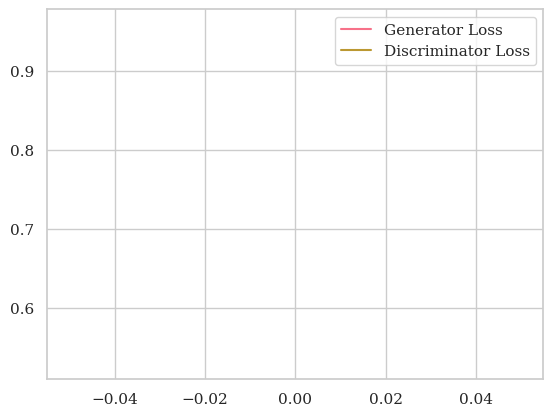

Epoch 2
Epoch 3
Step 60: Generator loss: 0.9093779762585957, discriminator loss: 0.6248886346817016


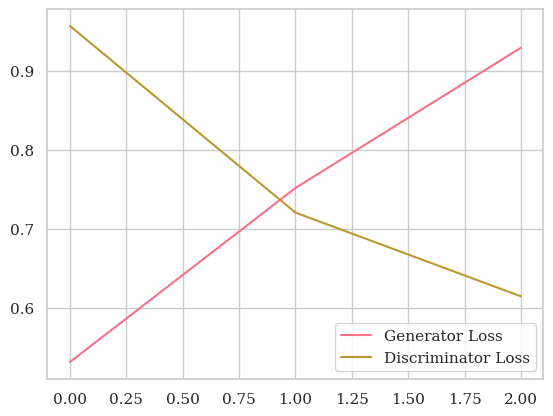

Epoch 4
Epoch 5
Step 90: Generator loss: 1.3007493297259012, discriminator loss: 0.44195840060710906


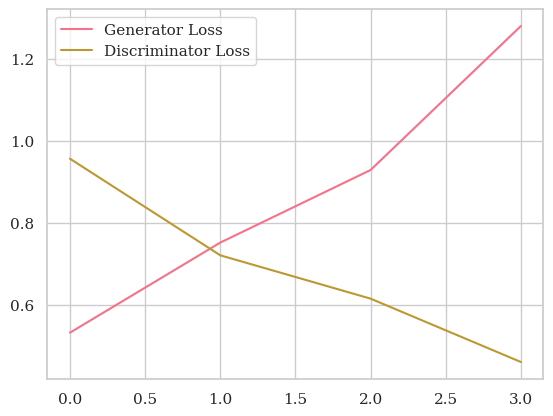

Epoch 6
Step 120: Generator loss: 1.0366432090600333, discriminator loss: 0.46599738697210946


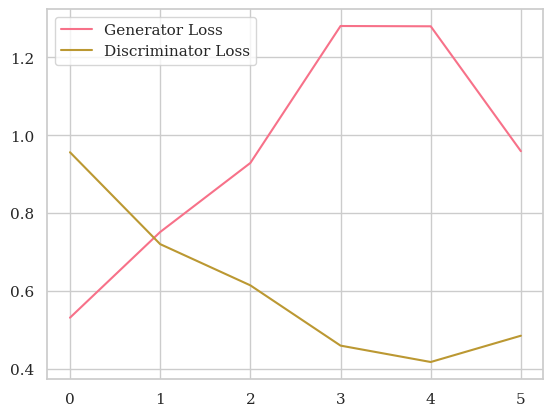

Epoch 7
Epoch 8
Step 150: Generator loss: 0.9239256342252096, discriminator loss: 0.4811077872912089


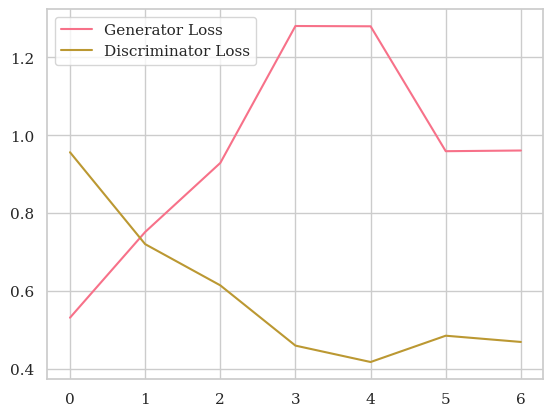

Epoch 9
Epoch 10
Step 180: Generator loss: 0.754565813144048, discriminator loss: 0.5407848119735718


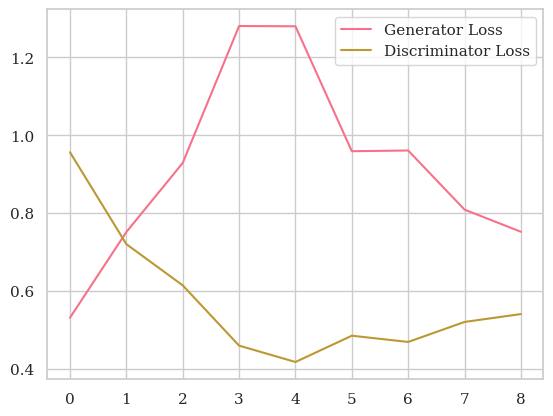

Epoch 11
Step 210: Generator loss: 0.8243153889973959, discriminator loss: 0.5058494706948599


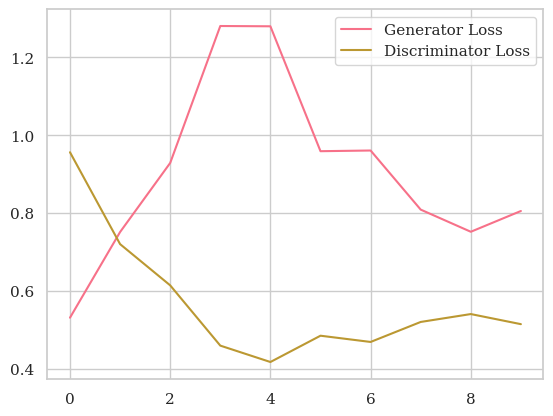

Epoch 12
Epoch 13
Step 240: Generator loss: 0.8771584928035736, discriminator loss: 0.4877061853806178


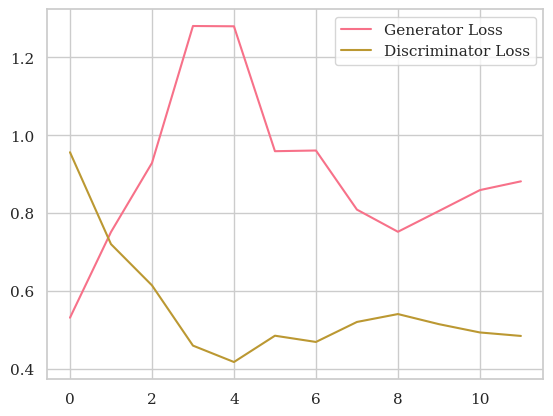

Epoch 14
Epoch 15
Step 270: Generator loss: 0.8924248874187469, discriminator loss: 0.47784061133861544


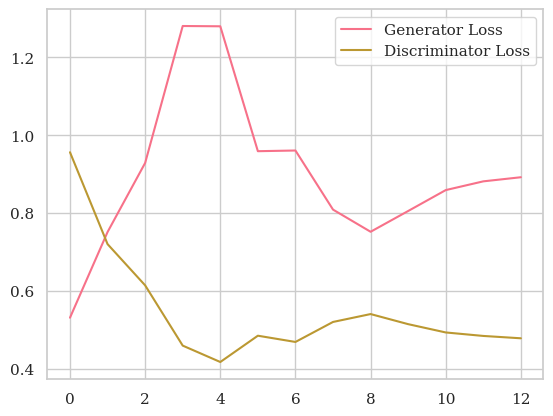

Epoch 16
Step 300: Generator loss: 0.8532610853513082, discriminator loss: 0.4924503574768702


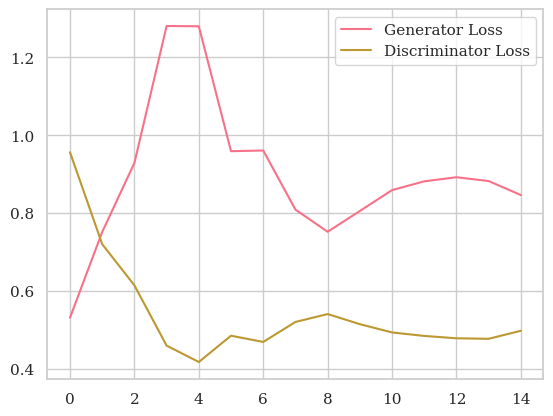

Epoch 17
Epoch 18
Step 330: Generator loss: 0.7998952269554138, discriminator loss: 0.5131742815176646


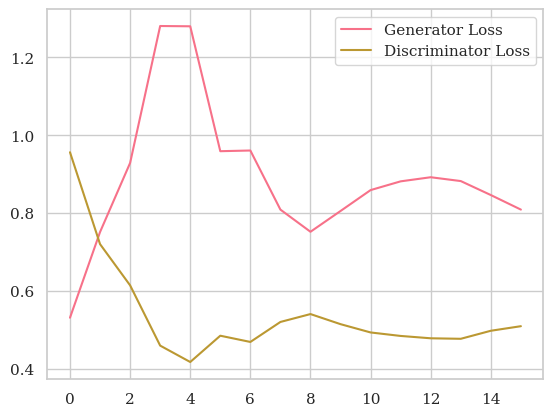

Epoch 19
Epoch 20
Step 360: Generator loss: 0.7793460786342621, discriminator loss: 0.5215741197268168


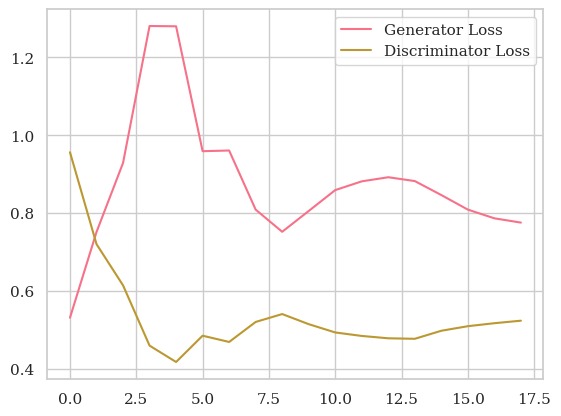

Epoch 21
Step 390: Generator loss: 0.7731703301270803, discriminator loss: 0.5251755913098654


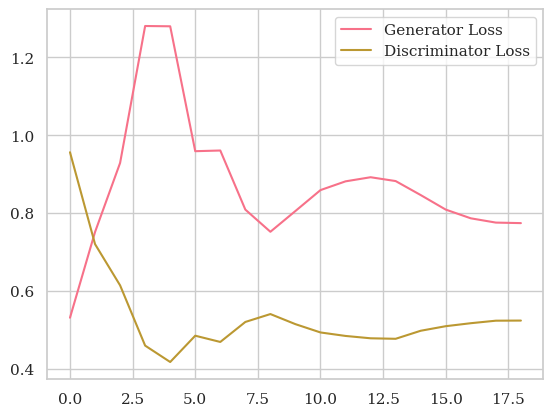

Epoch 22
Epoch 23
Step 420: Generator loss: 0.772450989484787, discriminator loss: 0.5229656378428141


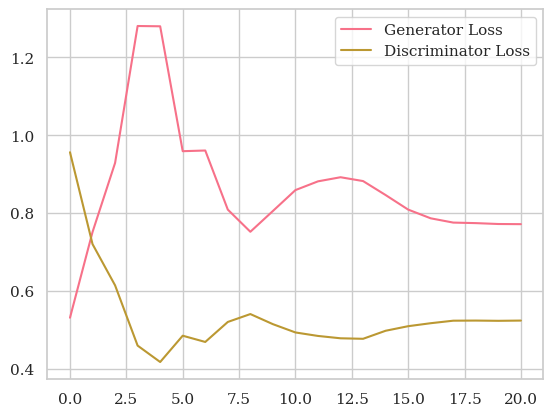

Epoch 24
Epoch 25
Step 450: Generator loss: 0.7702336788177491, discriminator loss: 0.5248557319243748


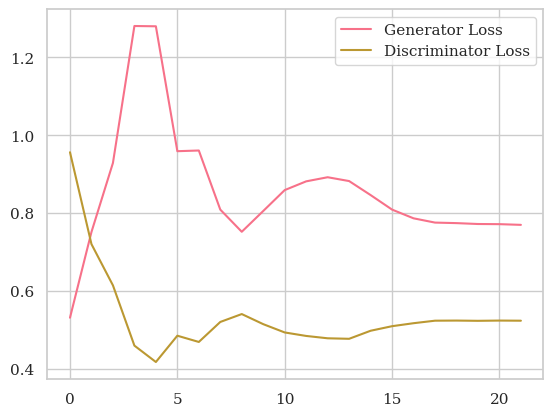

Epoch 26
Step 480: Generator loss: 0.7712737739086151, discriminator loss: 0.5245670775572459


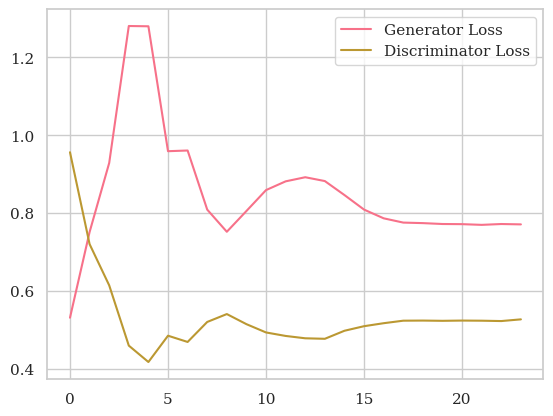

Epoch 27
Epoch 28
Step 510: Generator loss: 0.7685260832309723, discriminator loss: 0.5271979381640752


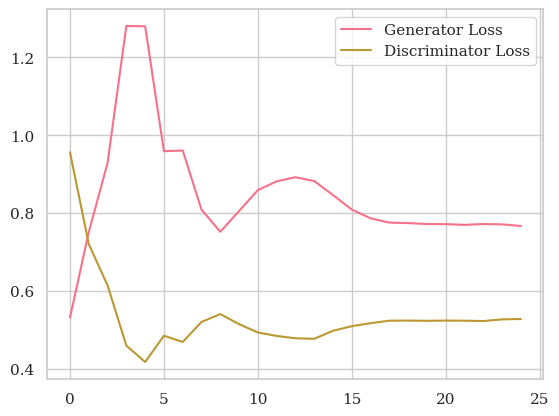

Epoch 29
Epoch 30
Step 540: Generator loss: 0.7719268560409546, discriminator loss: 0.5237839798132579


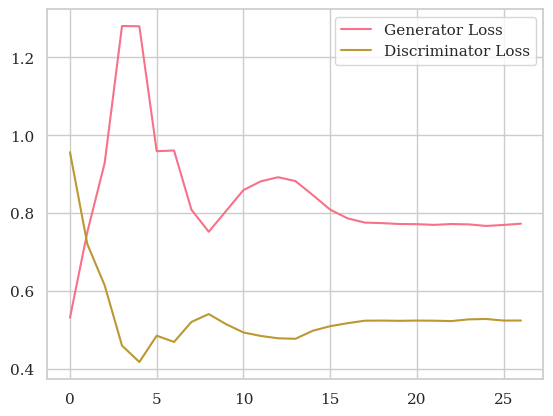

Epoch 31
Step 570: Generator loss: 0.7713610212008158, discriminator loss: 0.5268756171067556


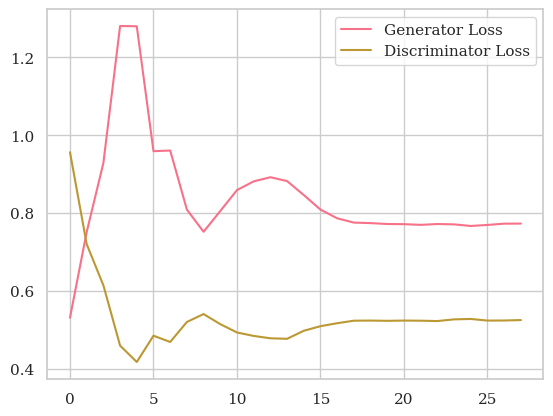

Epoch 32
Epoch 33
Step 600: Generator loss: 0.7710202515125275, discriminator loss: 0.5245349625746409


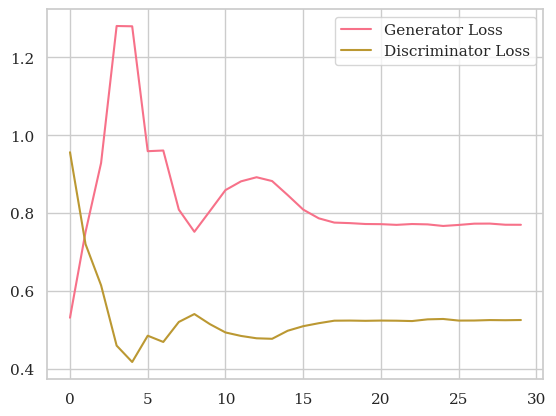

Epoch 34
Epoch 35
Step 630: Generator loss: 0.7725415011246999, discriminator loss: 0.5224609871705373


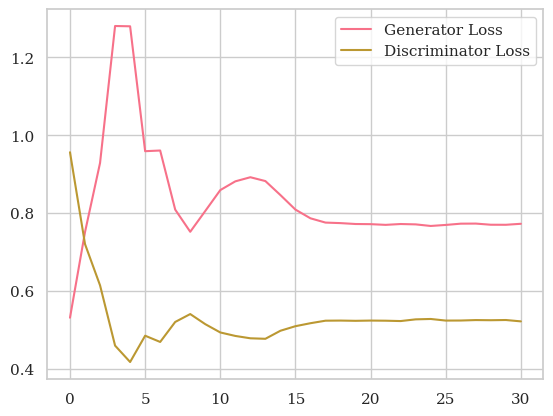

Epoch 36
Step 660: Generator loss: 0.7696889579296112, discriminator loss: 0.5254122694333394


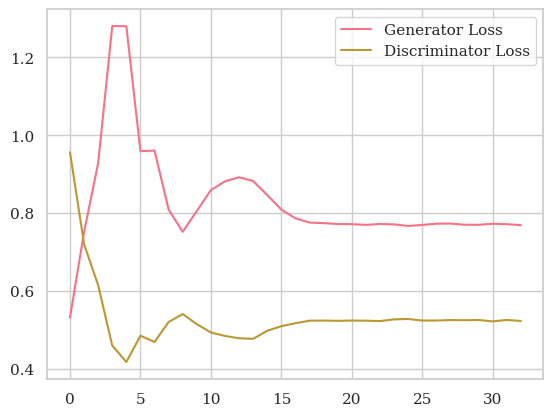

Epoch 37
Epoch 38
Step 690: Generator loss: 0.7707205315430959, discriminator loss: 0.5249969522158305


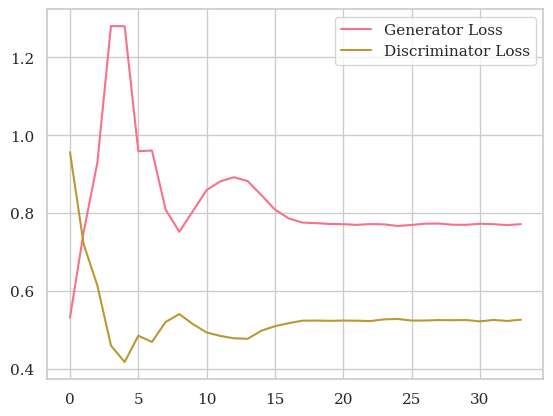

Epoch 39
Epoch 40
Step 720: Generator loss: 0.770905488729477, discriminator loss: 0.5252345144748688


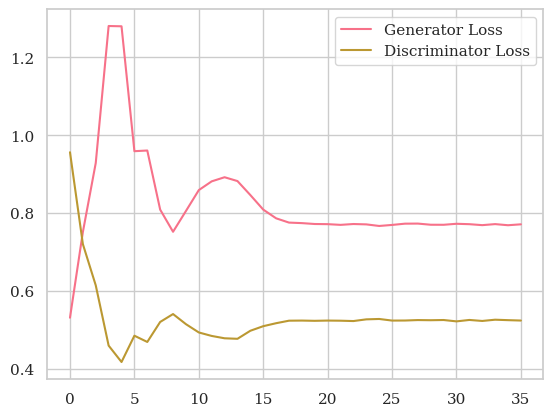

Epoch 41
Step 750: Generator loss: 0.7726703802744548, discriminator loss: 0.5258471071720123


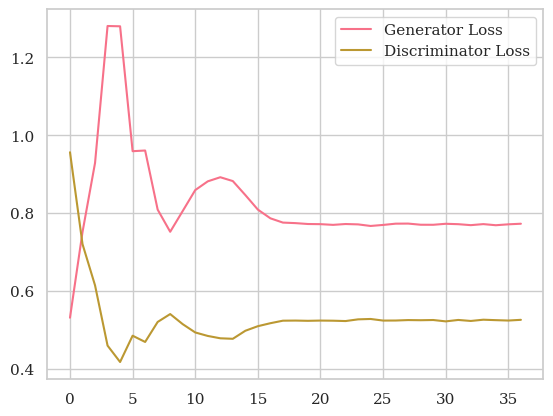

Epoch 42
Epoch 43
Step 780: Generator loss: 0.7687171618143718, discriminator loss: 0.5246270457903545
Epoch 57
Epoch 58
Step 1050: Generator loss: 0.7666719138622284, discriminator loss: 0.528781670331955


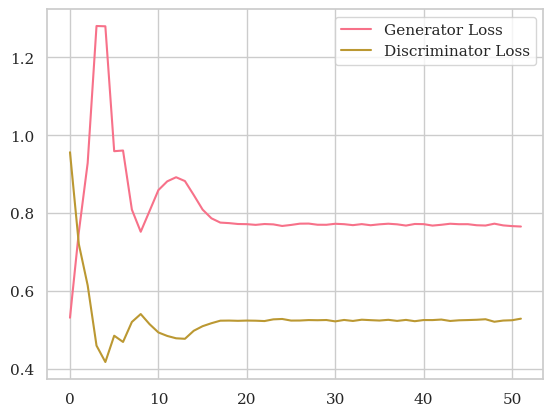

Epoch 59
Epoch 60
Step 1080: Generator loss: 0.7695487995942434, discriminator loss: 0.5246001899242401


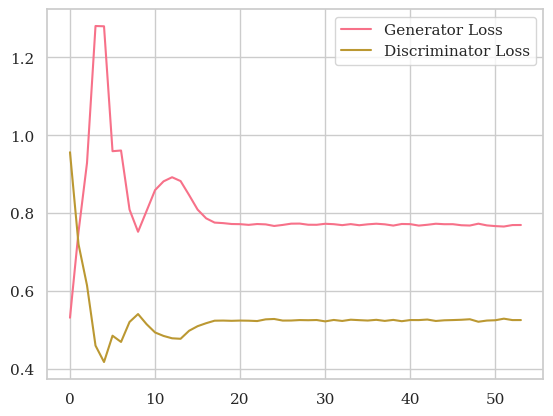

Epoch 61
Step 1110: Generator loss: 0.7709875484307607, discriminator loss: 0.5249696910381317


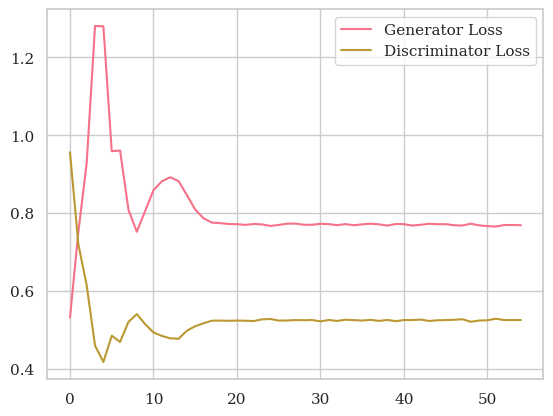

Epoch 62
Epoch 63
Step 1140: Generator loss: 0.7693974733352661, discriminator loss: 0.5254193286101023


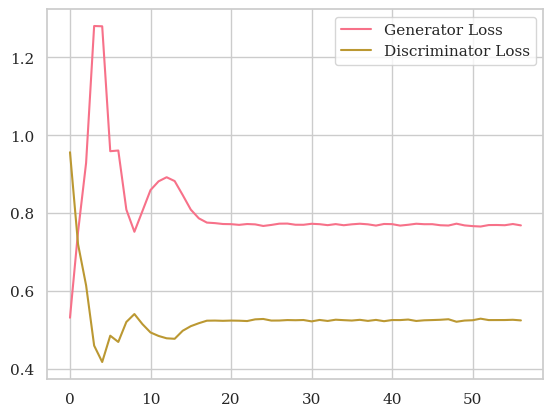

Epoch 64
Epoch 65
Step 1170: Generator loss: 0.7678332606951396, discriminator loss: 0.5253405034542084


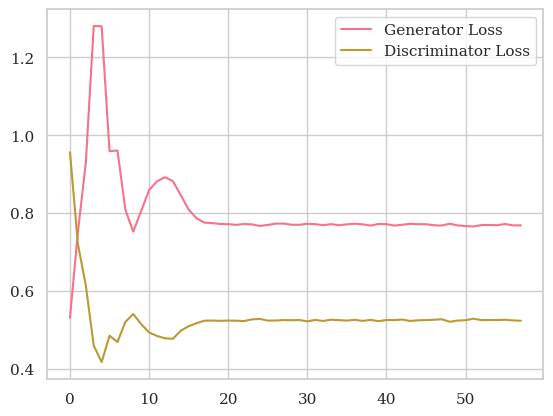

Epoch 66
Step 1200: Generator loss: 0.7695918381214142, discriminator loss: 0.5254341940085093


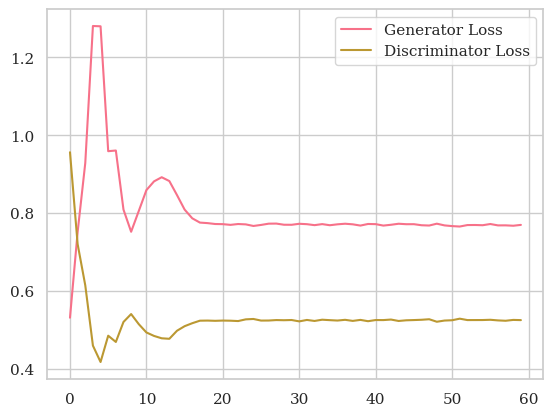

Epoch 67
Epoch 68
Step 1230: Generator loss: 0.7704179883003235, discriminator loss: 0.525102969010671


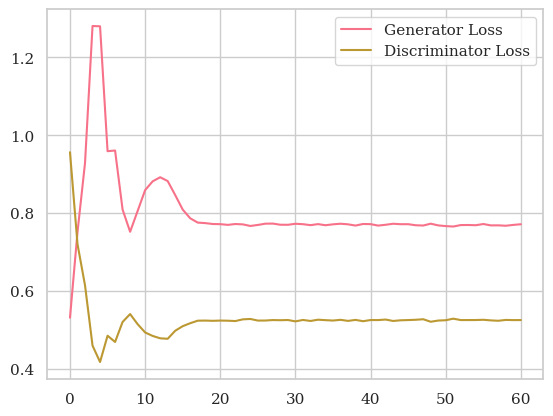

Epoch 69
Epoch 70
Step 1260: Generator loss: 0.7710363864898682, discriminator loss: 0.5245186309019725


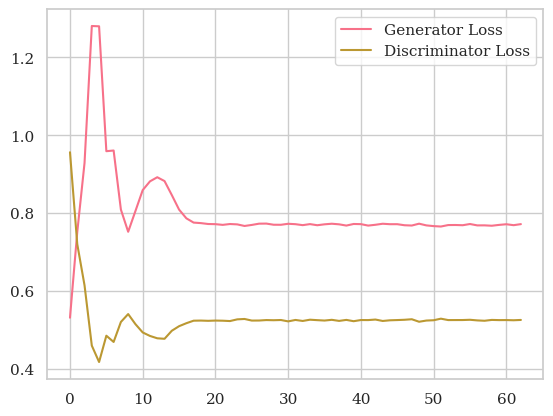

Epoch 71
Step 1290: Generator loss: 0.7685187300046284, discriminator loss: 0.527511457602183


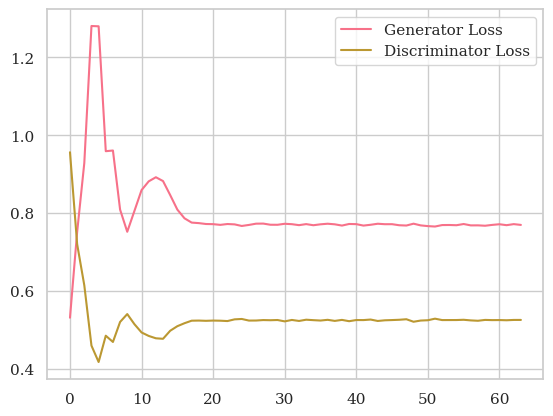

Epoch 72
Epoch 73
Step 1320: Generator loss: 0.7687832196553548, discriminator loss: 0.5231259743372599


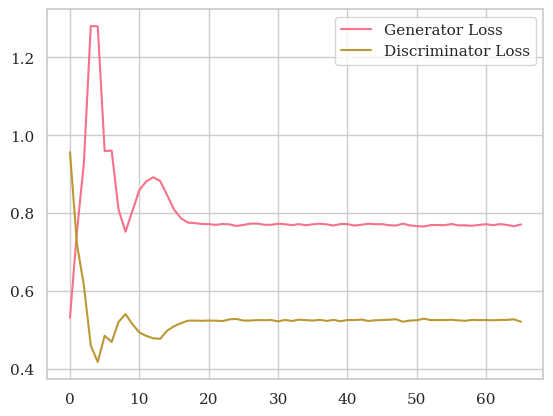

Epoch 74
Epoch 75
Step 1350: Generator loss: 0.7710145155588786, discriminator loss: 0.5267453710238139


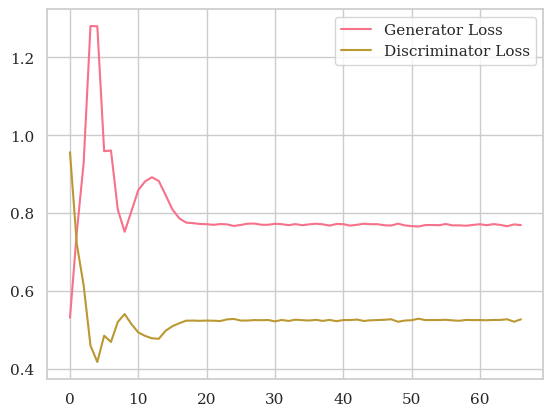

Epoch 76
Step 1380: Generator loss: 0.7692953209082286, discriminator loss: 0.5258540451526642


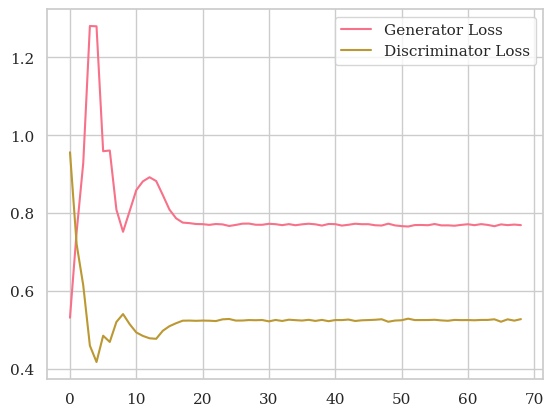

Epoch 77
Epoch 78
Step 1410: Generator loss: 0.7667612572511037, discriminator loss: 0.525526781876882


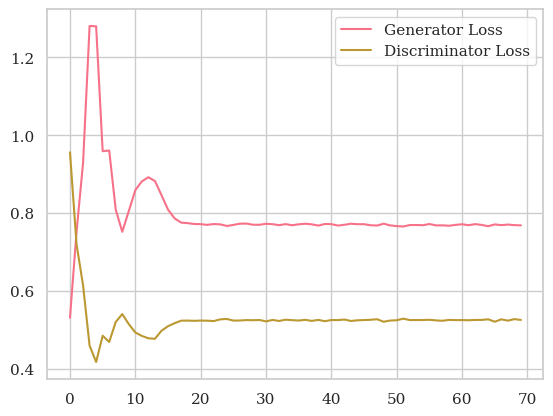

Epoch 79
Epoch 80
Step 1440: Generator loss: 0.770568174123764, discriminator loss: 0.5253450493017833


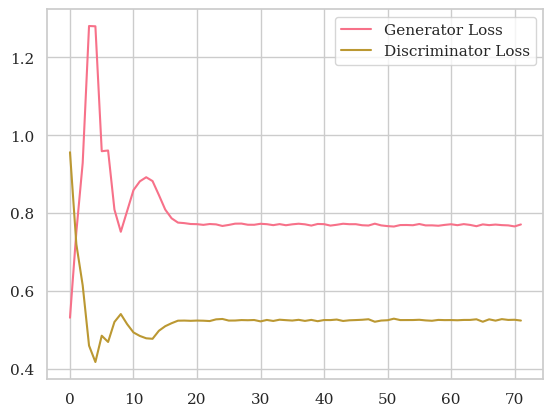

Epoch 81
Step 1470: Generator loss: 0.7695762495199839, discriminator loss: 0.5254852732022604


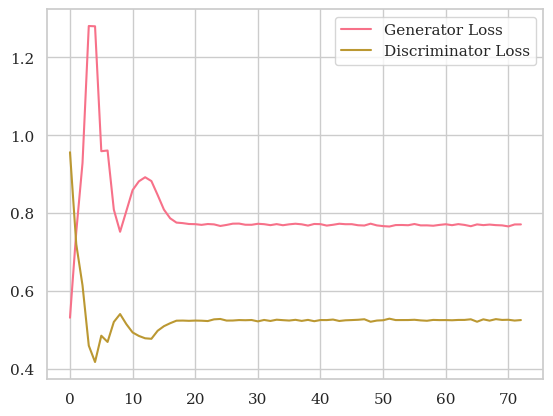

Epoch 82
Epoch 83
Step 1500: Generator loss: 0.7720578988393147, discriminator loss: 0.5257491827011108


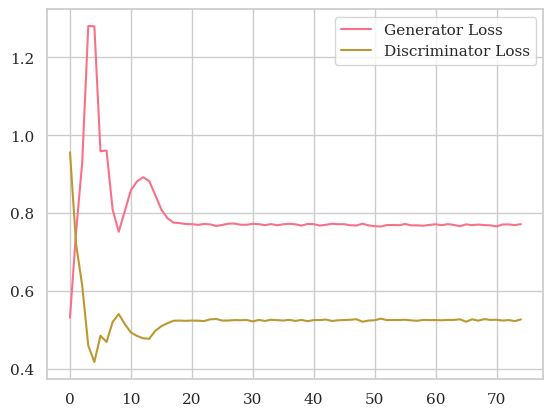

Epoch 84
Epoch 85
Step 1530: Generator loss: 0.767530620098114, discriminator loss: 0.5247720897197723


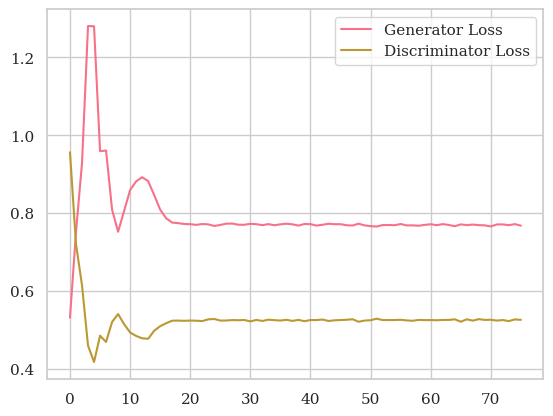

Epoch 86
Step 1560: Generator loss: 0.7718895435333252, discriminator loss: 0.5246716658274333


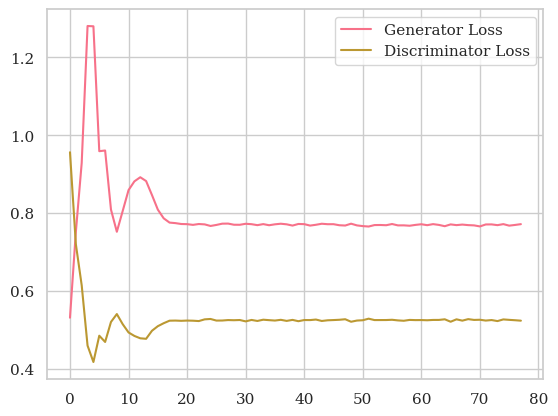

Epoch 87
Epoch 88
Step 1590: Generator loss: 0.7693577369054159, discriminator loss: 0.5267103830973308


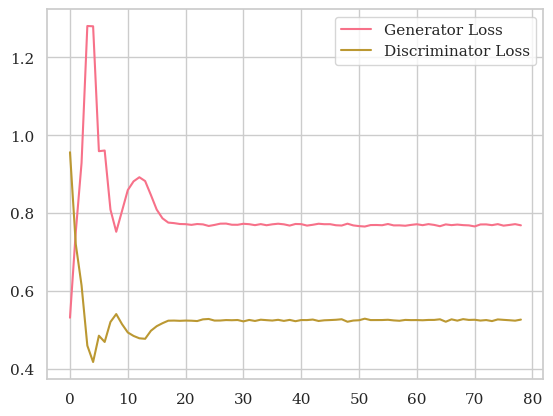

Epoch 89
Epoch 90
Step 1620: Generator loss: 0.7698590616385143, discriminator loss: 0.5252870380878448


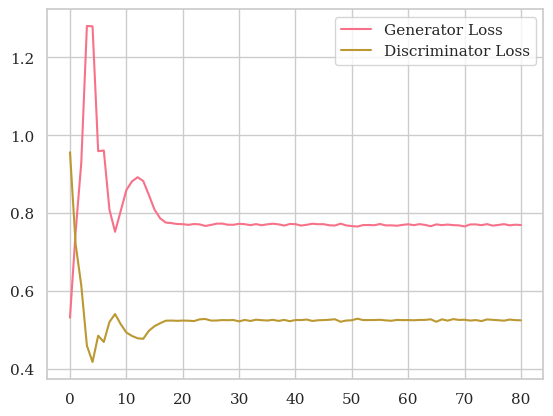

Epoch 91
Step 1650: Generator loss: 0.7681893646717072, discriminator loss: 0.5253468910853069


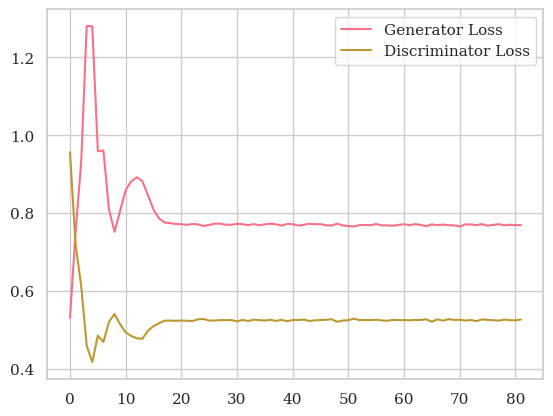

Epoch 92
Epoch 93
Step 1680: Generator loss: 0.7702575504779816, discriminator loss: 0.5251409431298574


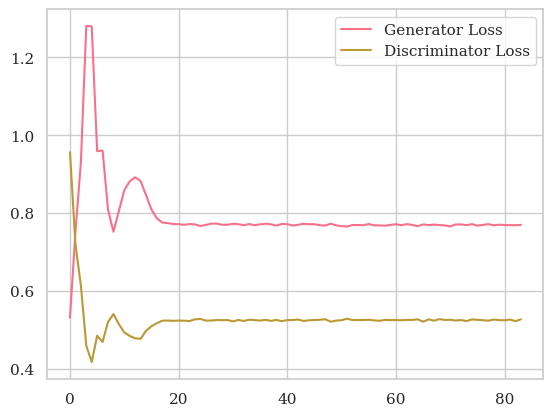

Epoch 94
Epoch 95
Step 1710: Generator loss: 0.7699253161748251, discriminator loss: 0.5255025903383891


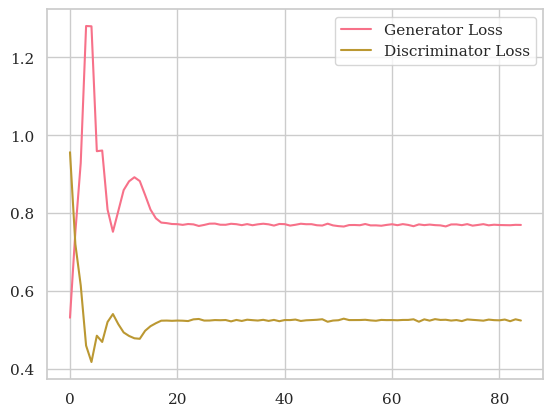

Epoch 96
Step 1740: Generator loss: 0.7684847831726074, discriminator loss: 0.5249873638153076


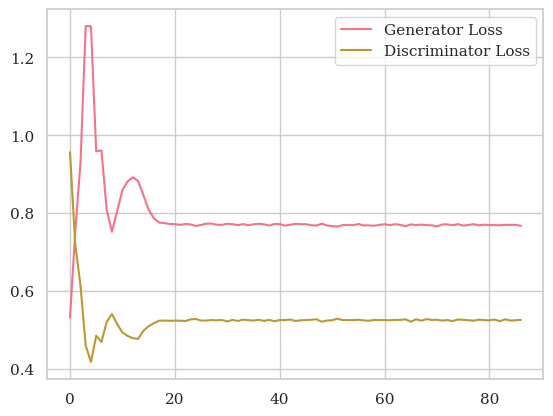

Epoch 97
Epoch 98
Step 1770: Generator loss: 0.7717834373315176, discriminator loss: 0.5256744821866354


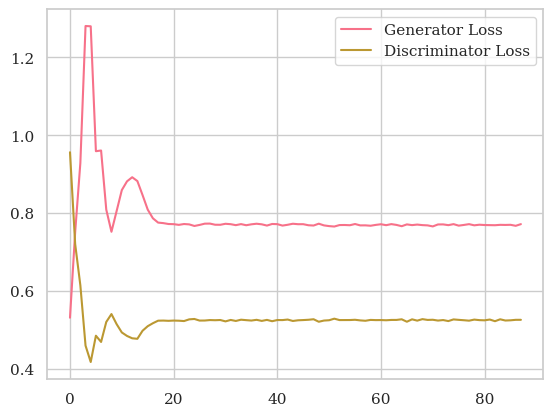

Epoch 99
Epoch 100
Step 1800: Generator loss: 0.7718494017918904, discriminator loss: 0.5239935795466105


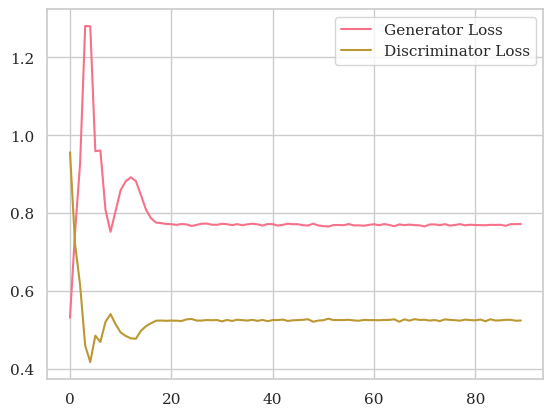

Epoch 101
Step 1830: Generator loss: 0.7741383790969849, discriminator loss: 0.5243786911169688


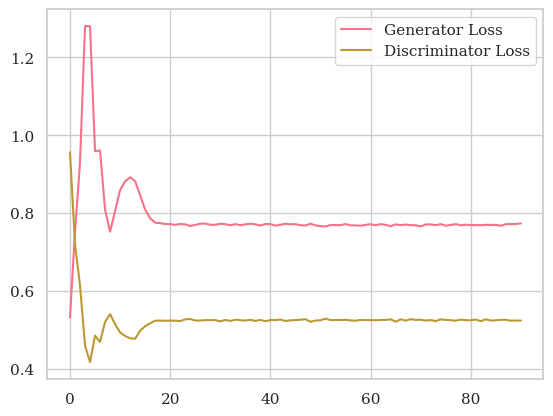

Epoch 102
Epoch 103
Step 1860: Generator loss: 0.7705573936303457, discriminator loss: 0.5244104743003846


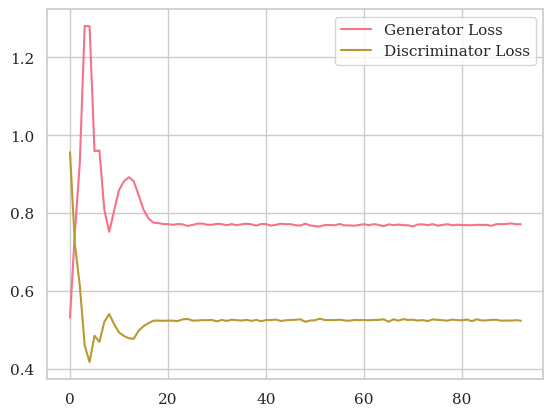

Epoch 104
Epoch 105
Step 1890: Generator loss: 0.7694568316141764, discriminator loss: 0.5257472534974416


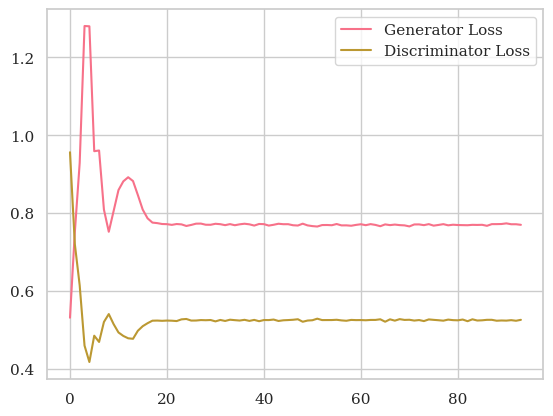

Epoch 106
Step 1920: Generator loss: 0.7711854875087738, discriminator loss: 0.5251539359490077


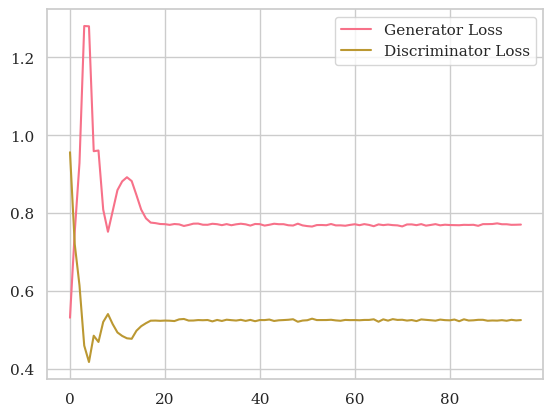

Epoch 107
Epoch 108
Step 1950: Generator loss: 0.7705396076043447, discriminator loss: 0.5254625499248504


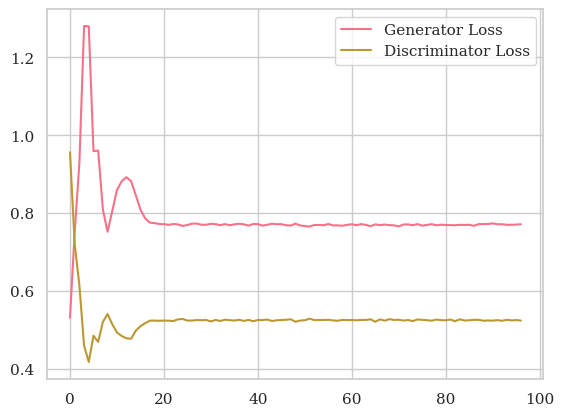

Epoch 109
Epoch 110
Step 1980: Generator loss: 0.7681771258513133, discriminator loss: 0.5252737462520599


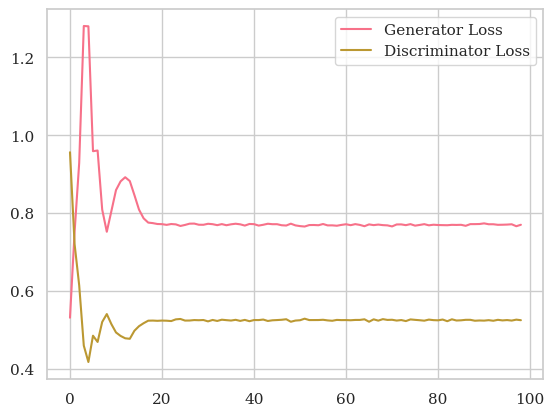

Epoch 111
Step 2010: Generator loss: 0.7706252336502075, discriminator loss: 0.5259959618250529


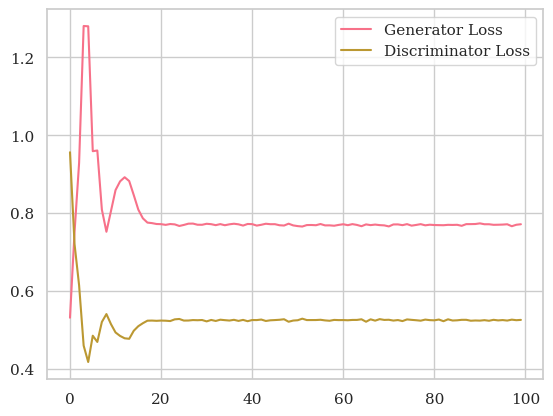

Epoch 112
Epoch 113
Step 2040: Generator loss: 0.772145809729894, discriminator loss: 0.5239582637945811


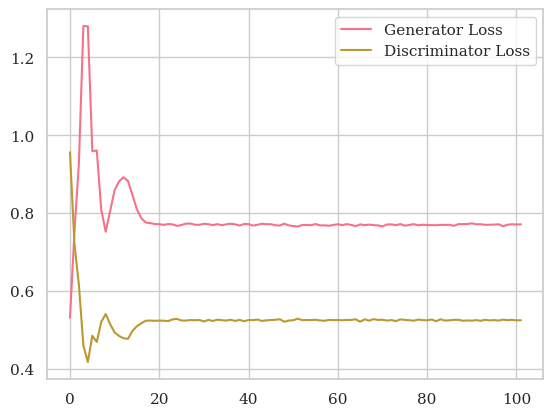

Epoch 114
Epoch 115
Step 2070: Generator loss: 0.7709799547990163, discriminator loss: 0.5243109583854675


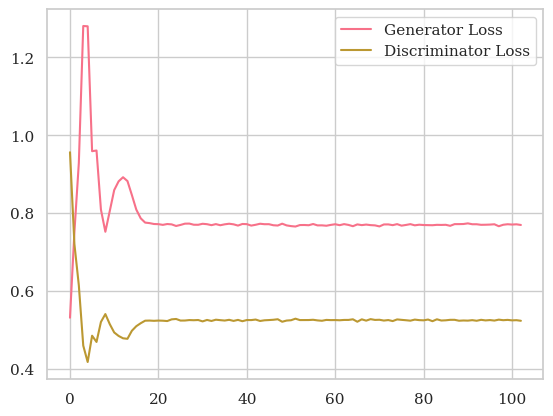

Epoch 116
Step 2100: Generator loss: 0.7704179445902507, discriminator loss: 0.5258869628111521


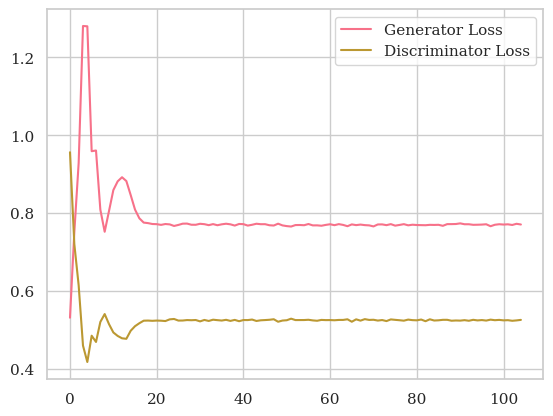

Epoch 117
Epoch 118
Step 2130: Generator loss: 0.7686824321746826, discriminator loss: 0.5260961532592774


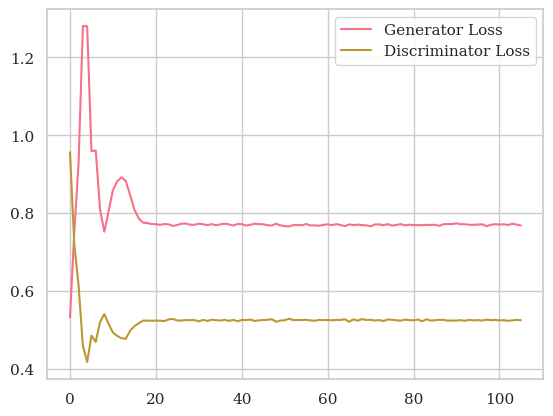

Epoch 119
Epoch 120
Step 2160: Generator loss: 0.7679161508878072, discriminator loss: 0.5256529808044433


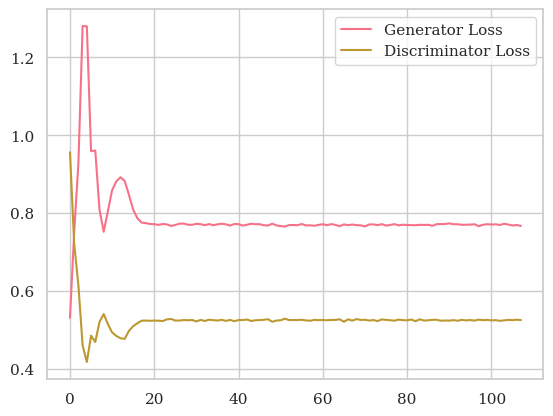

Epoch 121
Step 2190: Generator loss: 0.7693456470966339, discriminator loss: 0.52453919450442


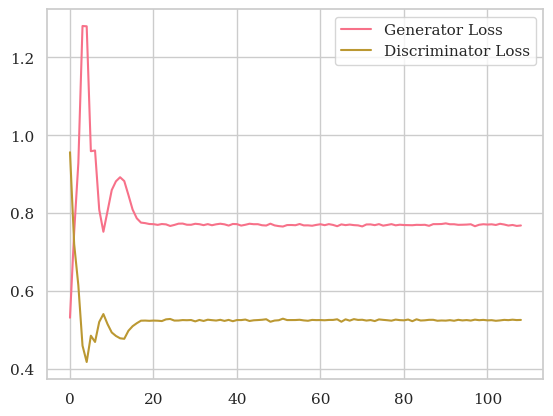

Epoch 122
Epoch 123
Step 2220: Generator loss: 0.7706792891025543, discriminator loss: 0.5252439161141713


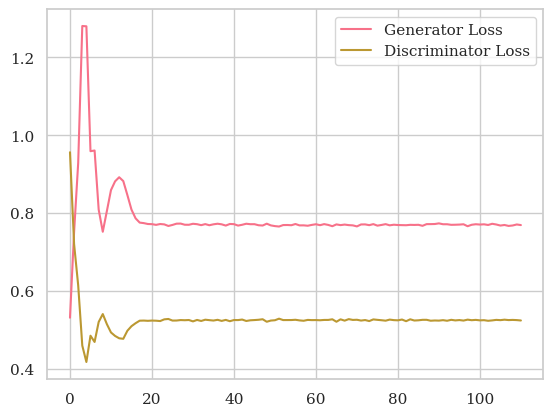

Epoch 124
Epoch 125
Step 2250: Generator loss: 0.7678856074810028, discriminator loss: 0.5265363732973735


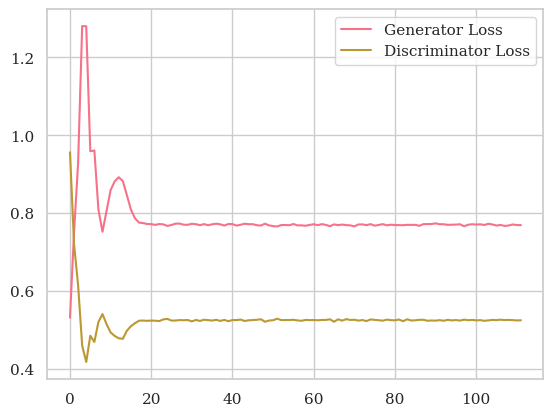

Epoch 126
Step 2280: Generator loss: 0.771112875143687, discriminator loss: 0.5257478773593902


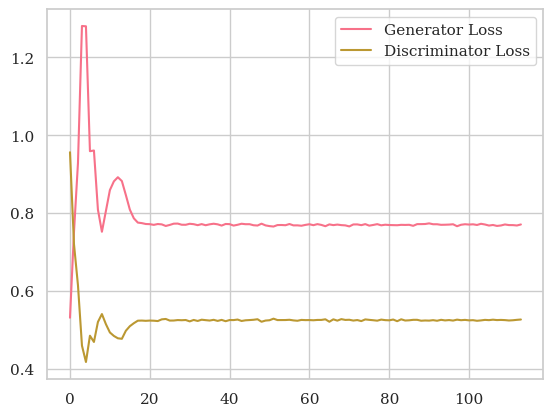

Epoch 127
Epoch 128
Step 2310: Generator loss: 0.7676496922969818, discriminator loss: 0.5244627455870311


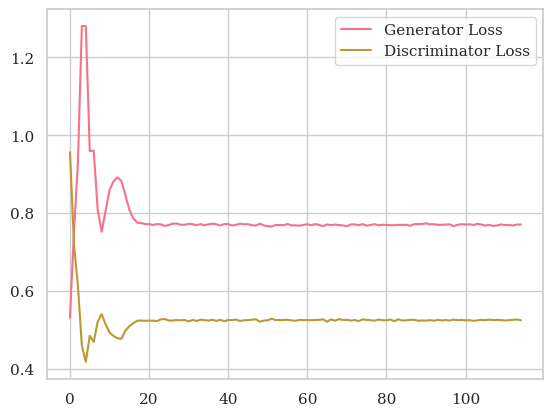

Epoch 129
Epoch 130
Step 2340: Generator loss: 0.7694453914960225, discriminator loss: 0.5266489485899607


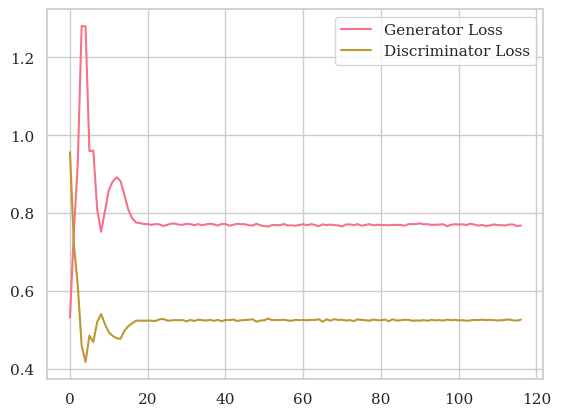

Epoch 131
Step 2370: Generator loss: 0.7696469843387603, discriminator loss: 0.5252075493335724


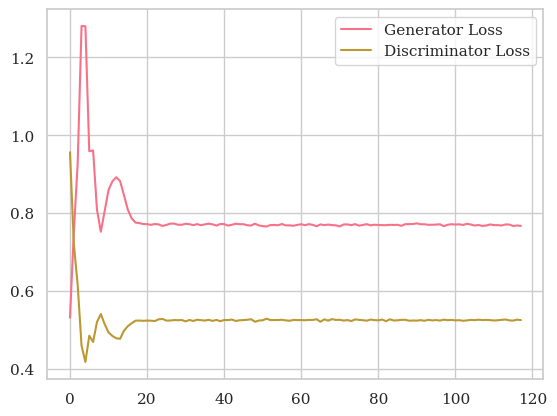

Epoch 132
Epoch 133
Step 2400: Generator loss: 0.7683125813802083, discriminator loss: 0.5272281308968861


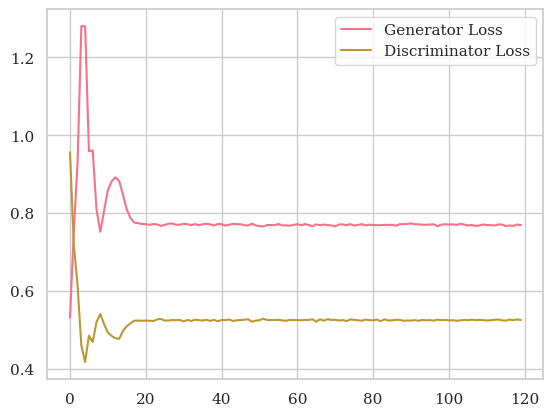

Epoch 134
Epoch 135
Step 2430: Generator loss: 0.7715881903966267, discriminator loss: 0.5242645621299744


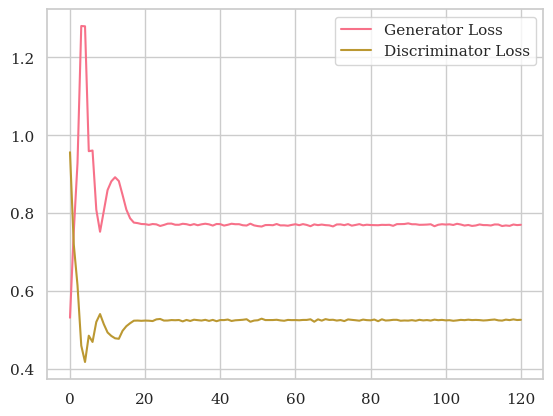

Epoch 136
Step 2460: Generator loss: 0.7716009338696798, discriminator loss: 0.5233678877353668


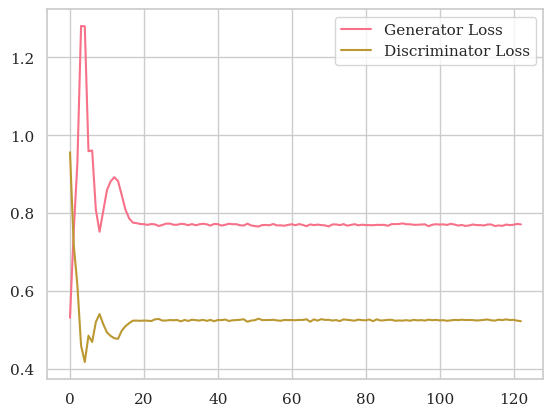

Epoch 137
Epoch 138
Step 2490: Generator loss: 0.7694484571615855, discriminator loss: 0.5262350777784983


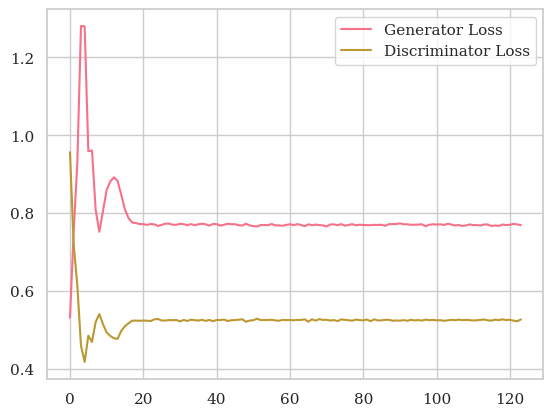

Epoch 139
Epoch 140
Step 2520: Generator loss: 0.7712998072306315, discriminator loss: 0.5237870494524638


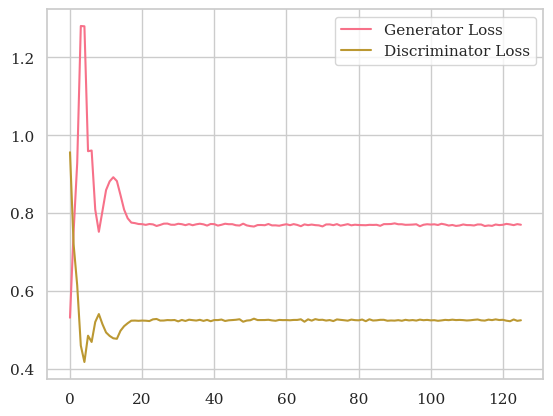

Epoch 141
Step 2550: Generator loss: 0.7679004152615865, discriminator loss: 0.5266075293223064


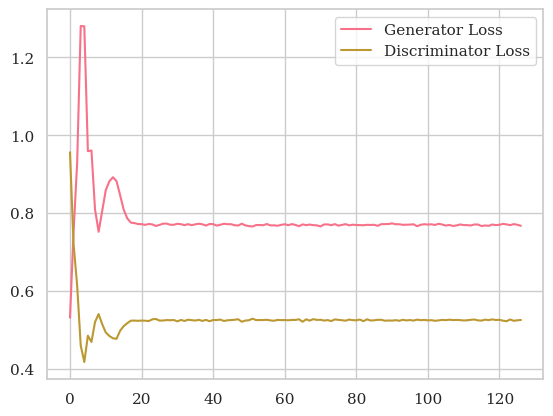

Epoch 142
Epoch 143
Step 2580: Generator loss: 0.7710626165072123, discriminator loss: 0.5245682120323181


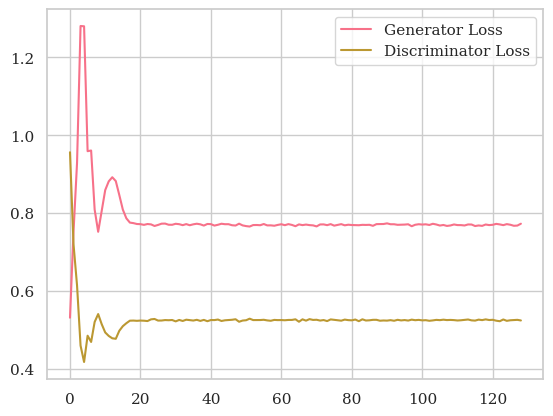

Epoch 144
Epoch 145
Step 2610: Generator loss: 0.7668625255425771, discriminator loss: 0.5261421382427216


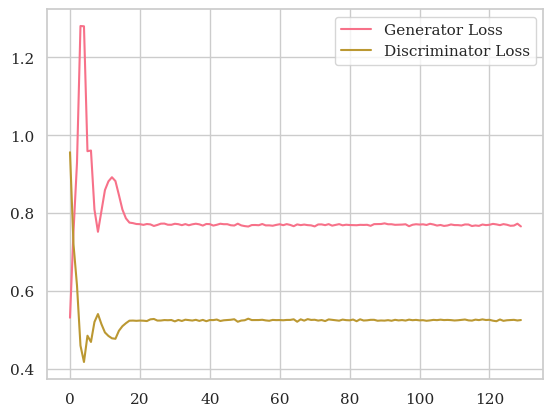

Epoch 146
Step 2640: Generator loss: 0.7695469776789348, discriminator loss: 0.5261894086996715


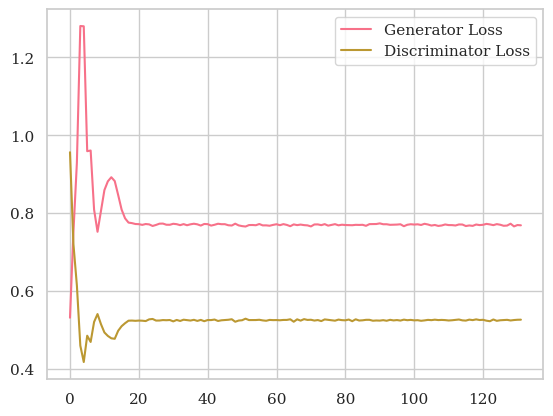

Epoch 147
Epoch 148
Step 2670: Generator loss: 0.7698126713434855, discriminator loss: 0.5248509546120962


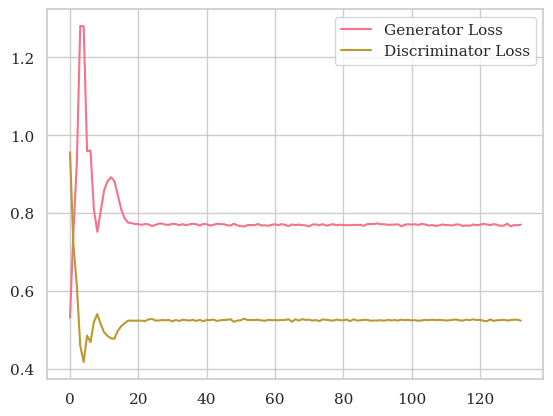

Epoch 149
Epoch 150
Step 2700: Generator loss: 0.7704389770825704, discriminator loss: 0.5255423208077749


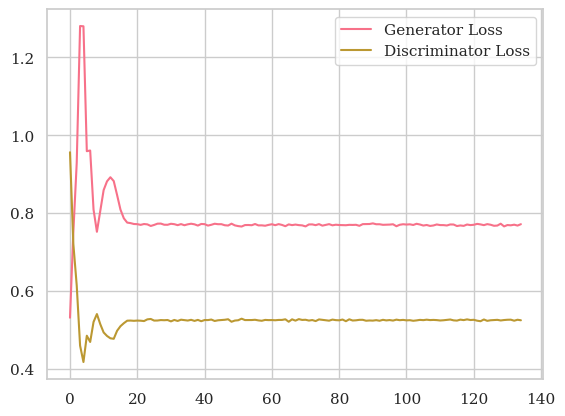

Epoch 151
Step 2730: Generator loss: 0.7696067333221436, discriminator loss: 0.5248526235421499


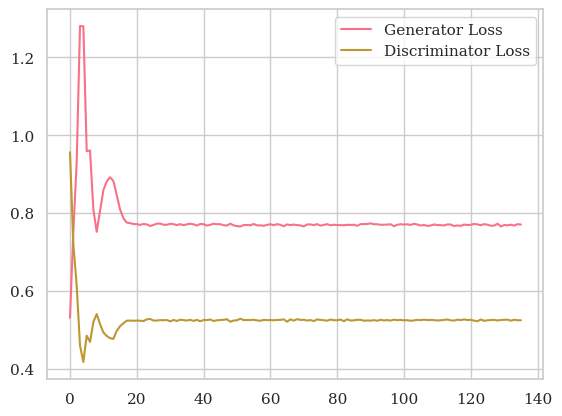

Epoch 152
Epoch 153
Step 2760: Generator loss: 0.7723998129367828, discriminator loss: 0.5251553336779277


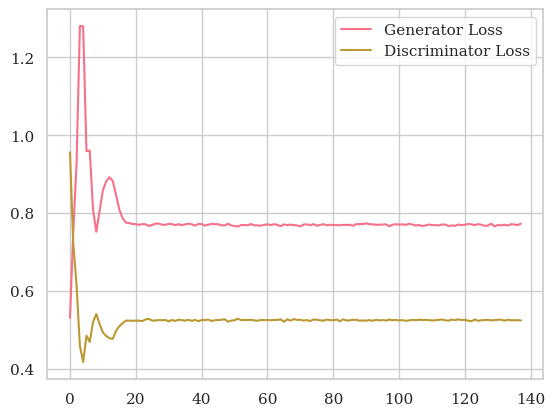

Epoch 154
Epoch 155
Step 2790: Generator loss: 0.7702777723471324, discriminator loss: 0.5256851494312287


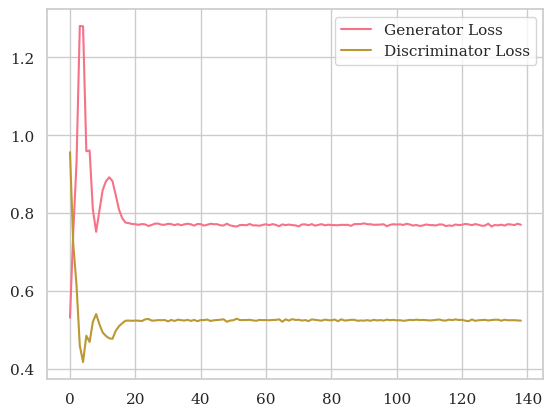

Epoch 156
Step 2820: Generator loss: 0.769520777463913, discriminator loss: 0.52479674021403


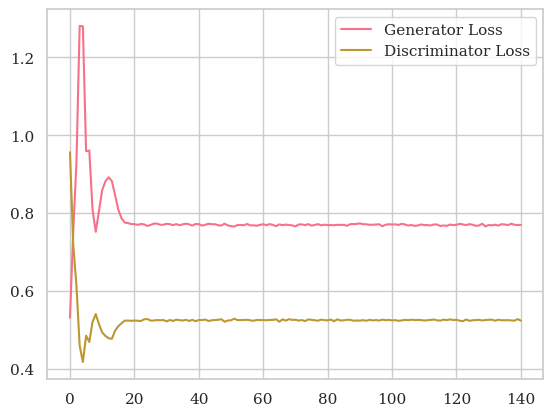

Epoch 157
Epoch 158
Step 2850: Generator loss: 0.7729356070359548, discriminator loss: 0.5229429940382639


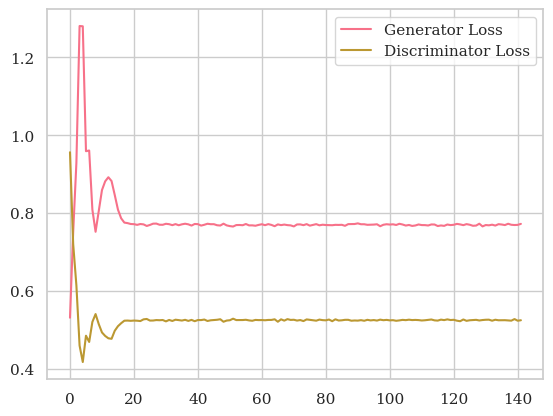

Epoch 159
Epoch 160
Step 2880: Generator loss: 0.7700708130995433, discriminator loss: 0.5263159950574239


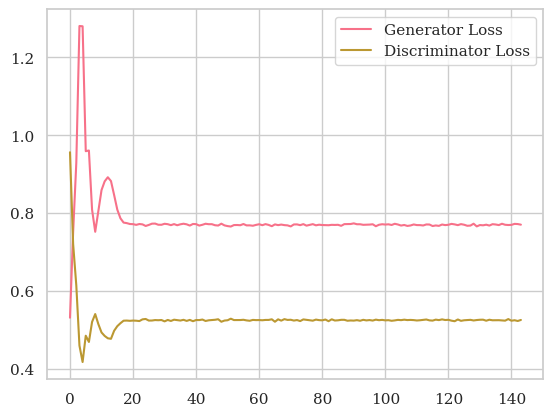

Epoch 161
Step 2910: Generator loss: 0.7706789294878642, discriminator loss: 0.526240348815918


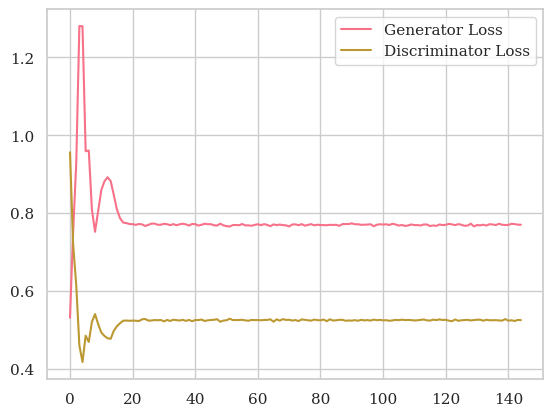

Epoch 162
Epoch 163
Step 2940: Generator loss: 0.770795218149821, discriminator loss: 0.52289097905159


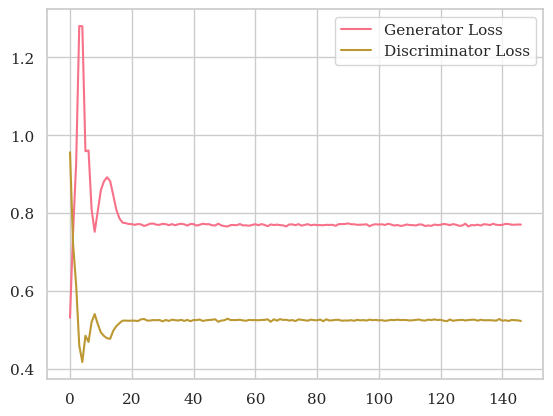

Epoch 164
Epoch 165
Step 2970: Generator loss: 0.7722928543885549, discriminator loss: 0.525837630033493


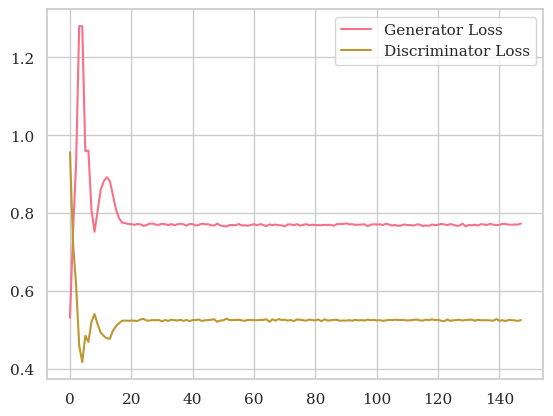

Epoch 166
Step 3000: Generator loss: 0.7721187671025594, discriminator loss: 0.524537307024002


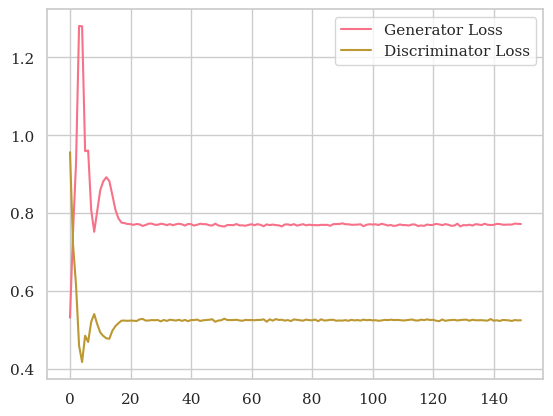

Epoch 167
Epoch 168
Step 3030: Generator loss: 0.7686946551005046, discriminator loss: 0.5258162260055542


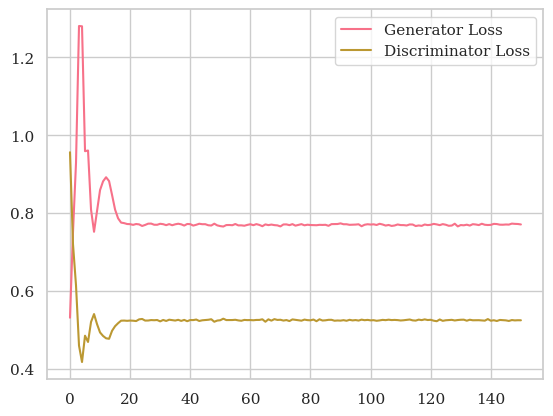

Epoch 169
Epoch 170
Step 3060: Generator loss: 0.7694502194722493, discriminator loss: 0.5244670907656351


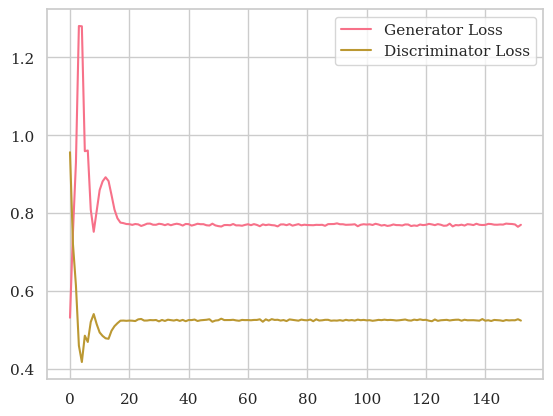

Epoch 171
Step 3090: Generator loss: 0.7693976660569509, discriminator loss: 0.5266063392162323


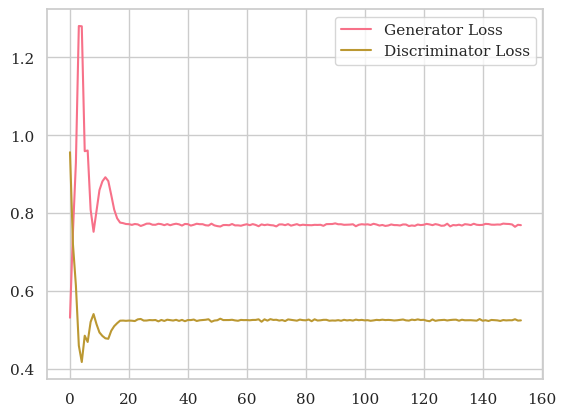

Epoch 172
Epoch 173
Step 3120: Generator loss: 0.7673142234484355, discriminator loss: 0.5258925795555115


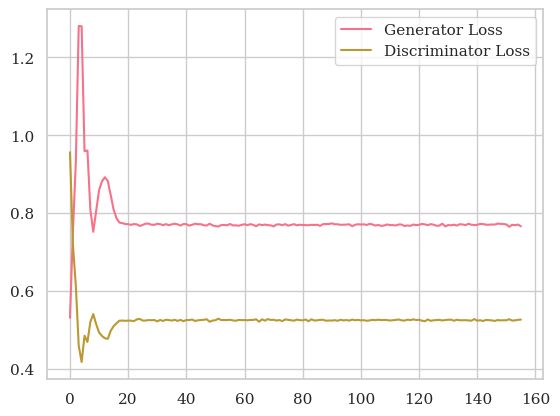

Epoch 174
Epoch 175
Step 3150: Generator loss: 0.7699846903483073, discriminator loss: 0.5249452392260233


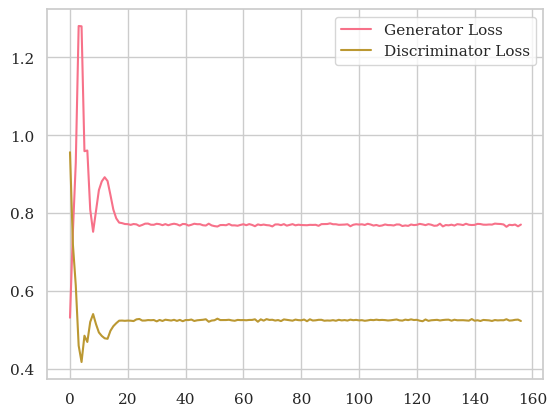

Epoch 176
Step 3180: Generator loss: 0.7698827544848125, discriminator loss: 0.526471491654714


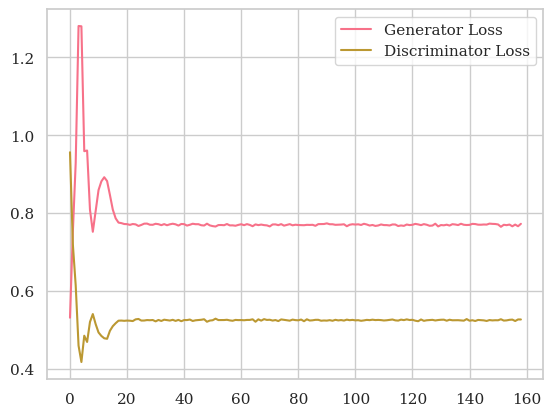

Epoch 177
Epoch 178
Step 3210: Generator loss: 0.772531141837438, discriminator loss: 0.5230697393417358


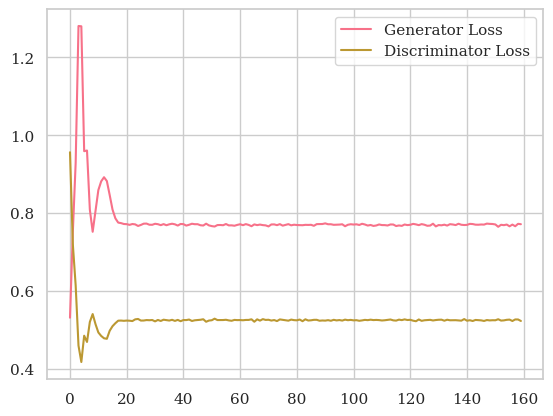

Epoch 179
Epoch 180
Step 3240: Generator loss: 0.7678053160508473, discriminator loss: 0.5262060304482777


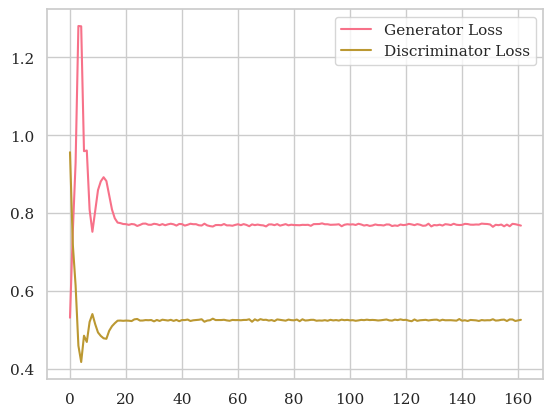

Epoch 181
Step 3270: Generator loss: 0.7690678596496582, discriminator loss: 0.5261988898118337


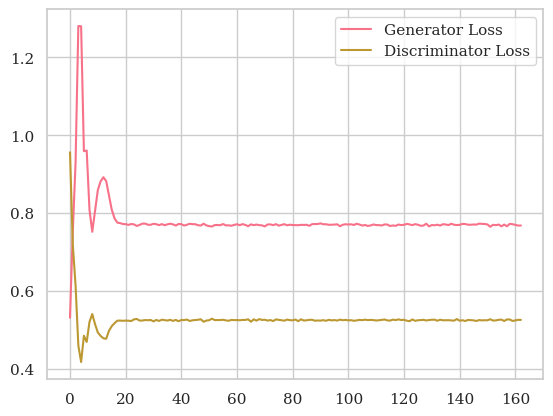

Epoch 182
Epoch 183
Step 3300: Generator loss: 0.7719444493452708, discriminator loss: 0.5248805304368337


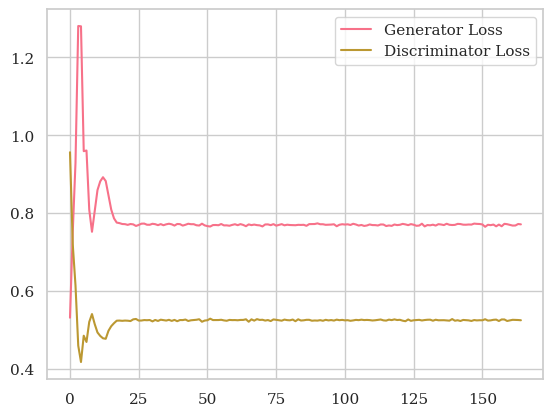

Epoch 184
Epoch 185
Step 3330: Generator loss: 0.7705052117506663, discriminator loss: 0.5241325497627258


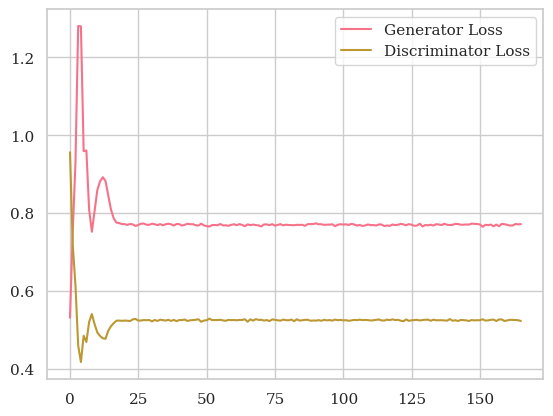

Epoch 186
Step 3360: Generator loss: 0.7717042028903961, discriminator loss: 0.5257164577643076


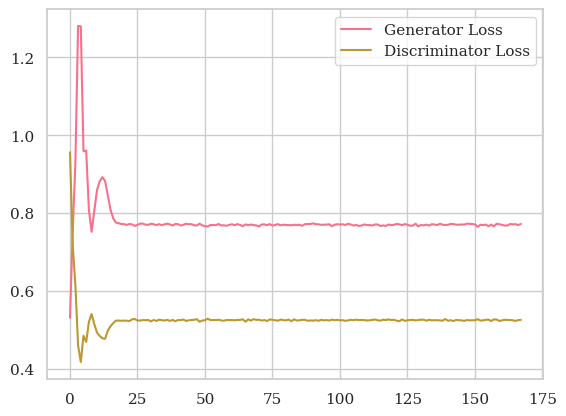

Epoch 187
Epoch 188
Step 3390: Generator loss: 0.7717217942078908, discriminator loss: 0.5237879872322082


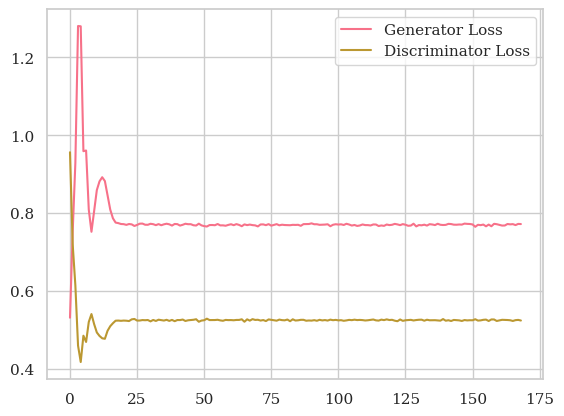

Epoch 189
Epoch 190
Step 3420: Generator loss: 0.7714267949263255, discriminator loss: 0.5249381184577941


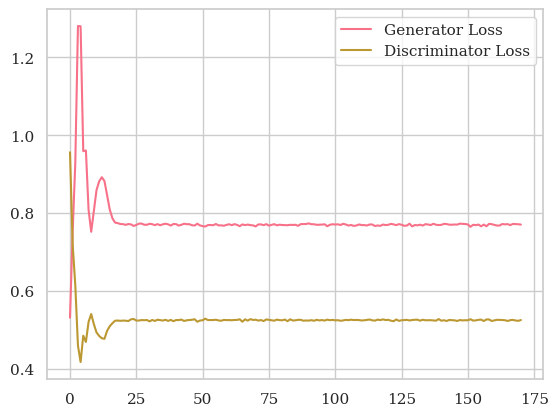

Epoch 191
Step 3450: Generator loss: 0.7702958365281423, discriminator loss: 0.5258244633674621


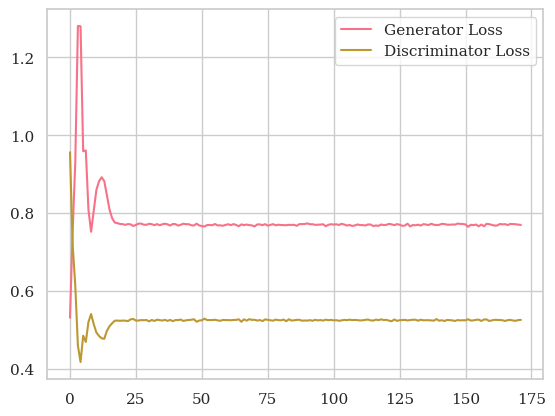

Epoch 192
Epoch 193
Step 3480: Generator loss: 0.7692874908447266, discriminator loss: 0.5259020288785299


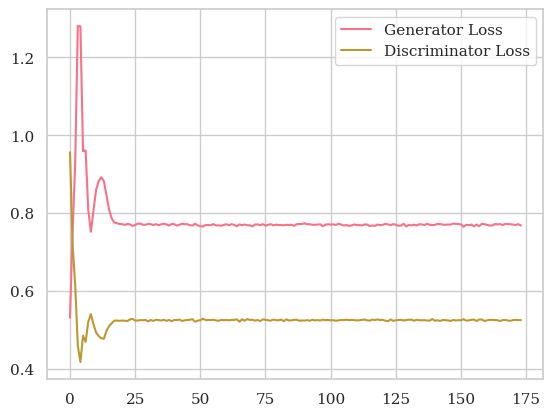

Epoch 194
Epoch 195
Step 3510: Generator loss: 0.7713352819283803, discriminator loss: 0.5249407927195231


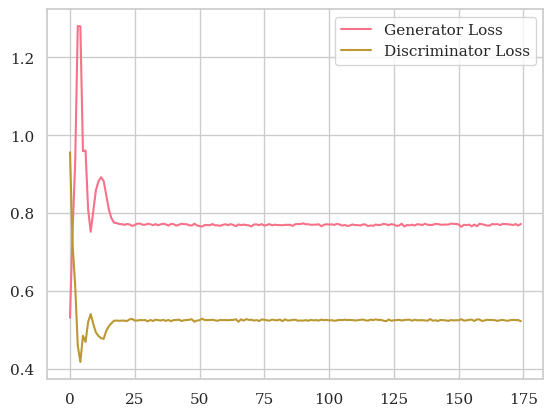

Epoch 196
Step 3540: Generator loss: 0.770979646841685, discriminator loss: 0.5244904855887095


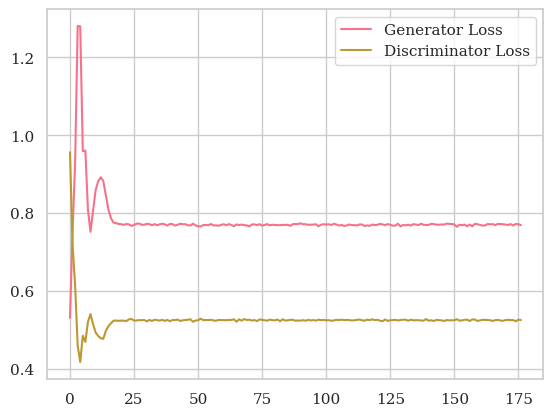

Epoch 197
Epoch 198
Step 3570: Generator loss: 0.7693427364031474, discriminator loss: 0.5245913664499918


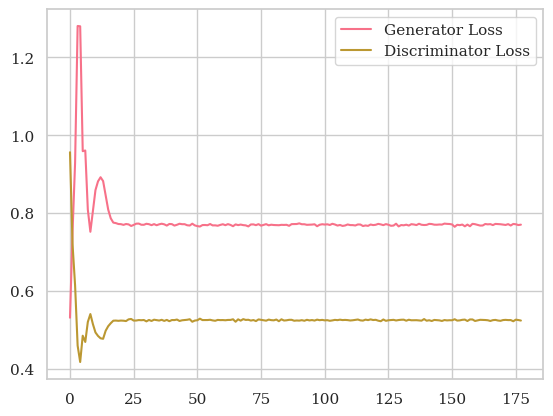

Epoch 199


In [218]:
n_epochs = 200
_, gen_loss, disc_loss = train(n_epochs)

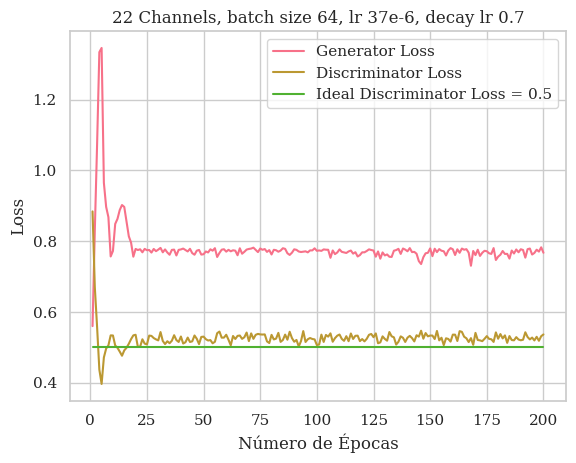

In [236]:
### Os gráficos serão salvos dentro da pasta Testes_Finais/nome_da_pasta
nome_da_pasta = "arquitetura_gan"
nome_do_arquivo = "22ch_batch16_lr1e5"
titulo = "22 Channels, batch size 64, lr 37e-6, decay lr 0.7"

path = "Testes_Finais/" + nome_da_pasta + "/" + nome_do_arquivo + ".png"
plt.plot(range(1,n_epochs+1), gen_loss, label="Generator Loss")
plt.plot(range(1,n_epochs+1), disc_loss,label="Discriminator Loss"  )
plt.plot(range(1,n_epochs+1), [0.5]*(n_epochs), label = "Ideal Discriminator Loss = 0.5")
plt.xlabel("Número de Épocas")
plt.ylabel("Loss")
plt.title(titulo)
plt.legend()
plt.savefig("22ch_batch64_lr37e6_decay7.png")

plt.show()

In [220]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [237]:
torch.save(gen.state_dict(), "gen_22ch_batch64_lr37e6_decay7.pt")
torch.save(disc.state_dict(), "disc_22ch_batch64_lr37e6_decay7.pt")
from IPython.display import FileLink
# FileLink(r'gen_22ch_batch64_lr37e6_decay7.pt')
FileLink(r'22ch_batch64_lr37e6_decay7.png')
# FileLink(r'disc_22ch_batch64_lr37e6_decay7.pt')




/kaggle/working/22ch_batch64_lr37e6_decay7.png

# Exploration

In [ ]:
# Function to generate samples

def generate_samples(label, n_samples, generator):
    '''
    Function for generating samples, once the generator has been trained
        label: label of the movement to be sampled. See dictionary below
        {'feet': 0, 'left_hand': 1, 'right_hand': 2, 'tongue': 3}
        n_samples: number of samples to be generated
        generator: the trained generator
    '''

    noise_4_gen = get_noise(n_samples, z_dim, device=device)
    label = get_one_hot_labels(torch.Tensor([label]).long(), n_classes).repeat(n_samples,1)
    
    noise_and_labels = combine_vectors(noise_4_gen, label.to(device))
    fake = gen(noise_and_labels)
    return fake


In [ ]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

In [ ]:
# Remembering labels
print(my_eeg_data.windows_dataset.datasets[0].windows.event_id)

# Computing Dimensions for GAN

In [ ]:
from math import floor

def compute_dim_TransConv2D(Hin, 
                        kernel_size=1, 
                        stride=1,
                        padding = 0,
                        dilation = 1,
                        output_padding = 0
        
        ):
    return ((Hin - 1)*stride) - (2*padding)+ (dilation*(kernel_size - 1)) + output_padding + 1

def compute_dim_Conv2D(Hin, 
                kernel_size=50, 
                stride=4,
                padding = 0,
                dilation = 1
                ):
    return floor( (Hin + (2*padding) - (dilation*(kernel_size-1)) -1)/(stride) + 1 ) 

## For EEG CG


In [ ]:
compute_dim_TransConv2D(
    compute_dim_TransConv2D(
        compute_dim_TransConv2D(
            compute_dim_TransConv2D(1, kernel_size=3, stride = 1
            ), kernel_size=4, stride = 3
        ),kernel_size=3, stride = 2
    ),kernel_size=2, stride = 1
)

In [ ]:
compute_dim_Conv2D(compute_dim_Conv2D(compute_dim_Conv2D(22, kernel_size = 4, stride = 3
                                                        ) , kernel_size = 3, stride = 2
                                     ), kernel_size = 3, stride = 1
                  )

In [ ]:
self.make_disc_block(im_chan, hidden_dim,        kernel_size = (1,50), stride = (2,4)),
self.make_disc_block(hidden_dim, hidden_dim * 2, kernel_size = (1,50), stride = (2,4)),
self.make_disc_block(hidden_dim * 2, 1,          kernel_size = (1,10), stride = (2,1), final_layer=True),
